In [1]:
#환경 설정 & 라이브러리 임포트
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

from google.colab import drive
drive.mount('/content/drive')


PROJECT_DIR = "/content/drive/MyDrive/spanish_verb_project"
os.makedirs(PROJECT_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "best_model.pt")
print("Best model will be saved to:", BEST_MODEL_PATH)

print("프로젝트 폴더:", PROJECT_DIR)

Device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best model will be saved to: /content/drive/MyDrive/spanish_verb_project/best_model.pt
프로젝트 폴더: /content/drive/MyDrive/spanish_verb_project


In [2]:
#데이터 로드
PROJECT_DIR = "/content/drive/MyDrive/spanish_verb_project"
DATA_PATH = os.path.join(PROJECT_DIR, "data.csv")
df = pd.read_csv(DATA_PATH)

print("Data Path:", DATA_PATH)
print("Data Shape:", df.shape)
print(df.head())
print()
print("Columns:", df.columns.tolist())


Data Path: /content/drive/MyDrive/spanish_verb_project/data.csv
Data Shape: (65927, 4)
          verb        mood        tense person
0     abandono  indicative      present    1sg
1   abandonaré  indicative       future    1sg
2   abandonaba  indicative    imperfect    1sg
3     abandoné  indicative    preterite    1sg
4  abandonaría  indicative  conditional    1sg

Columns: ['verb', 'mood', 'tense', 'person']


In [3]:
#레이블 인코딩 + 문자 사전 생성

# (1) 레이블 인코더: mood / tense / person
mood_le = LabelEncoder()
tense_le = LabelEncoder()
person_le = LabelEncoder()

df["mood_id"] = mood_le.fit_transform(df["mood"])
df["tense_id"] = tense_le.fit_transform(df["tense"])
df["person_id"] = person_le.fit_transform(df["person"])

print("Mood classes:", mood_le.classes_)
print("Tense classes:", tense_le.classes_)
print("Person classes:", person_le.classes_)

# (2) 문자 사전 생성
all_chars = set()
for v in df["verb"].astype(str):
    all_chars.update(list(v.lower()))

char_to_id = {"<PAD>": 0, "<UNK>": 1}
for i, ch in enumerate(sorted(all_chars), start=2):
    char_to_id[ch] = i

id_to_char = {v: k for k, v in char_to_id.items()}
vocab_size = len(char_to_id)
print("Vocab size:", vocab_size)


Mood classes: ['imperative' 'indicative' 'subjunctive']
Tense classes: ['conditional' 'conditional_perfect' 'future' 'future_perfect' 'imperfect'
 'pluperfect' 'present' 'present_perfect' 'preterite' 'preterite_anterior']
Person classes: ['1pl' '1sg' '2pl' '2sg' '3pl' '3sg']
Vocab size: 34


In [4]:
#Train / Val / Test 분할

# 일단 섞기
df_shuffled = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

# Test 셋 저장
train_path = os.path.join(PROJECT_DIR, "train_dataset.csv")
val_path   = os.path.join(PROJECT_DIR, "val_dataset.csv")
test_path  = os.path.join(PROJECT_DIR, "test_dataset.csv")

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved train/val/test to:")
print("  ", train_path)
print("  ", val_path)
print("  ", test_path)
test_df.to_csv("/content/test_dataset.csv", index=False)
print("Test dataset saved to /content/test_dataset.csv")


Train size: 52741
Val size: 6593
Test size: 6593
Saved train/val/test to:
   /content/drive/MyDrive/spanish_verb_project/train_dataset.csv
   /content/drive/MyDrive/spanish_verb_project/val_dataset.csv
   /content/drive/MyDrive/spanish_verb_project/test_dataset.csv
Test dataset saved to /content/test_dataset.csv


In [5]:
#Dataset / DataLoader 정의

MAX_LEN = 20   # 동사 최대 길이 (긴 건 잘라내고, 짧은 건 PAD)

class VerbDataset(Dataset):
    def __init__(self, df, char_to_id, max_len=20):
        self.df = df.reset_index(drop=True)
        self.char_to_id = char_to_id
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        verb = str(row["verb"]).lower()

        # 문자 → ID
        ids = [self.char_to_id.get(ch, self.char_to_id["<UNK>"]) for ch in verb]

        # padding / truncation
        if len(ids) < self.max_len:
            ids += [self.char_to_id["<PAD>"]] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]

        x = torch.tensor(ids, dtype=torch.long)
        y_mood   = torch.tensor(row["mood_id"], dtype=torch.long)
        y_tense  = torch.tensor(row["tense_id"], dtype=torch.long)
        y_person = torch.tensor(row["person_id"], dtype=torch.long)

        return x, y_mood, y_tense, y_person

train_dataset = VerbDataset(train_df, char_to_id, max_len=MAX_LEN)
val_dataset   = VerbDataset(val_df,   char_to_id, max_len=MAX_LEN)

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader)


(413, 52)

In [6]:
#Char 기반 Multi-Head LSTM 모델 정의

class CharLSTMMultiHead(nn.Module):
    def __init__(self, vocab_size, embed_dim,
                 hidden_dim, num_layers,
                 num_moods, num_tenses, num_persons,
                 dropout=0.5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_out_dim = hidden_dim * 2  # bidirectional

        # 각 라벨별 head
        self.mood_head = nn.Sequential(
            nn.Linear(lstm_out_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_moods),
        )
        self.tense_head = nn.Sequential(
            nn.Linear(lstm_out_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_tenses),
        )
        self.person_head = nn.Sequential(
            nn.Linear(lstm_out_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_persons),
        )

    def forward(self, x):
        emb = self.embedding(x)            # (B, L, E)
        out, (h_n, c_n) = self.lstm(emb)   # h_n: (num_layers*2, B, H)

        # 마지막 레이어의 forward / backward hidden state 결합
        h_forward  = h_n[-2]   # (B, H)
        h_backward = h_n[-1]   # (B, H)
        h = torch.cat([h_forward, h_backward], dim=1)  # (B, 2H)

        mood_logits   = self.mood_head(h)
        tense_logits  = self.tense_head(h)
        person_logits = self.person_head(h)

        return mood_logits, tense_logits, person_logits

num_moods   = df["mood_id"].nunique()
num_tenses  = df["tense_id"].nunique()
num_persons = df["person_id"].nunique()

model = CharLSTMMultiHead(
    vocab_size=vocab_size,
    embed_dim=64,
    hidden_dim=256,
    num_layers=3,
    num_moods=num_moods,
    num_tenses=num_tenses,
    num_persons=num_persons,
    dropout=0.5
).to(device)

print(model)


CharLSTMMultiHead(
  (embedding): Embedding(34, 64, padding_idx=0)
  (lstm): LSTM(64, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (mood_head): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
  (tense_head): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (person_head): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [7]:
#손실 함수, 옵티마이저, 간단 Metric

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def calc_batch_acc(logits, labels):
    preds = logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct, total


In [8]:
#학습 루프

EPOCHS = 20
best_val_loss = float("inf")

# Early Stopping 변수 추가
PATIENCE = 10  # 검증 손실이 개선되지 않아도 버틸 에폭 수
patience_counter = 0

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
}

for epoch in range(1, EPOCHS+1):
    # ---- Training ----
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y_mood, y_tense, y_person in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        x = x.to(device)
        y_mood = y_mood.to(device)
        y_tense = y_tense.to(device)
        y_person = y_person.to(device)

        optimizer.zero_grad()
        out_mood, out_tense, out_person = model(x)

        loss_mood   = criterion(out_mood, y_mood)
        loss_tense  = criterion(out_tense, y_tense)
        loss_person = criterion(out_person, y_person)

        loss = loss_mood + loss_tense + loss_person
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        # 간단한 "전체 평균 정확도": 세 head 모두 맞은 비율
        mood_pred   = out_mood.argmax(1)
        tense_pred  = out_tense.argmax(1)
        person_pred = out_person.argmax(1)

        all_correct = (
            (mood_pred == y_mood) &
            (tense_pred == y_tense) &
            (person_pred == y_person)
        ).sum().item()

        total_correct += all_correct
        total_samples += x.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc  = total_correct / total_samples

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for x, y_mood, y_tense, y_person in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            x = x.to(device)
            y_mood = y_mood.to(device)
            y_tense = y_tense.to(device)
            y_person = y_person.to(device)

            out_mood, out_tense, out_person = model(x)

            loss_mood   = criterion(out_mood, y_mood)
            loss_tense  = criterion(out_tense, y_tense)
            loss_person = criterion(out_person, y_person)

            loss = loss_mood + loss_tense + loss_person
            val_loss += loss.item()

            mood_pred   = out_mood.argmax(1)
            tense_pred  = out_tense.argmax(1)
            person_pred = out_person.argmax(1)

            all_correct = (
                (mood_pred == y_mood) &
                (tense_pred == y_tense) &
                (person_pred == y_person)
            ).sum().item()

            val_correct += all_correct
            val_samples += x.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc  = val_correct / val_samples

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Exact Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Exact Acc: {val_acc:.4f}")


    if val_loss < best_val_loss:
        # 손실이 개선되었을 경우
        best_val_loss = val_loss
        patience_counter = 0  # 카운터 리셋
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.")
        print("    →", BEST_MODEL_PATH)
    else:
        # 손실이 개선되지 않았을 경우
        patience_counter += 1
        print(f"  ✗ Validation loss did not improve. Patience: {patience_counter}/{PATIENCE}")

    # Early Stopping 조건 확인
    if patience_counter >= PATIENCE:
        print(f"\n Early stopping triggered. Validation loss has not improved for {PATIENCE} epochs.")
        break  # 메인 학습 루프를 중단


Epoch 1 [Val]: 100%|██████████| 52/52 [00:01<00:00, 49.46it/s]



Epoch 1/20
  Train Loss: 1.1916 | Train Exact Acc: 0.6351
  Val   Loss: 0.3764 | Val   Exact Acc: 0.8312
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 2 [Val]: 100%|██████████| 52/52 [00:01<00:00, 48.57it/s]



Epoch 2/20
  Train Loss: 0.3857 | Train Exact Acc: 0.8303
  Val   Loss: 0.3226 | Val   Exact Acc: 0.8504
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 3 [Val]: 100%|██████████| 52/52 [00:01<00:00, 35.77it/s]



Epoch 3/20
  Train Loss: 0.3393 | Train Exact Acc: 0.8408
  Val   Loss: 0.3019 | Val   Exact Acc: 0.8474
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 4 [Val]: 100%|██████████| 52/52 [00:01<00:00, 42.50it/s]



Epoch 4/20
  Train Loss: 0.3055 | Train Exact Acc: 0.8488
  Val   Loss: 0.2676 | Val   Exact Acc: 0.8682
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 5 [Val]: 100%|██████████| 52/52 [00:01<00:00, 48.87it/s]



Epoch 5/20
  Train Loss: 0.2826 | Train Exact Acc: 0.8533
  Val   Loss: 0.2534 | Val   Exact Acc: 0.8632
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 6 [Val]: 100%|██████████| 52/52 [00:01<00:00, 50.93it/s]



Epoch 6/20
  Train Loss: 0.2601 | Train Exact Acc: 0.8598
  Val   Loss: 0.2305 | Val   Exact Acc: 0.8709
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 7 [Val]: 100%|██████████| 52/52 [00:01<00:00, 46.73it/s]



Epoch 7/20
  Train Loss: 0.2392 | Train Exact Acc: 0.8667
  Val   Loss: 0.2451 | Val   Exact Acc: 0.8667
  ✗ Validation loss did not improve. Patience: 1/10


Epoch 8 [Val]: 100%|██████████| 52/52 [00:01<00:00, 37.00it/s]



Epoch 8/20
  Train Loss: 0.2283 | Train Exact Acc: 0.8673
  Val   Loss: 0.2123 | Val   Exact Acc: 0.8781
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 9 [Val]: 100%|██████████| 52/52 [00:01<00:00, 48.40it/s]



Epoch 9/20
  Train Loss: 0.2246 | Train Exact Acc: 0.8675
  Val   Loss: 0.2139 | Val   Exact Acc: 0.8818
  ✗ Validation loss did not improve. Patience: 1/10


Epoch 10 [Val]: 100%|██████████| 52/52 [00:01<00:00, 50.38it/s]



Epoch 10/20
  Train Loss: 0.2169 | Train Exact Acc: 0.8706
  Val   Loss: 0.2126 | Val   Exact Acc: 0.8724
  ✗ Validation loss did not improve. Patience: 2/10


Epoch 11 [Val]: 100%|██████████| 52/52 [00:01<00:00, 49.64it/s]



Epoch 11/20
  Train Loss: 0.2155 | Train Exact Acc: 0.8692
  Val   Loss: 0.2146 | Val   Exact Acc: 0.8864
  ✗ Validation loss did not improve. Patience: 3/10


Epoch 12 [Val]: 100%|██████████| 52/52 [00:01<00:00, 49.32it/s]



Epoch 12/20
  Train Loss: 0.2161 | Train Exact Acc: 0.8696
  Val   Loss: 0.2094 | Val   Exact Acc: 0.8700
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 13 [Val]: 100%|██████████| 52/52 [00:01<00:00, 34.96it/s]



Epoch 13/20
  Train Loss: 0.2117 | Train Exact Acc: 0.8704
  Val   Loss: 0.2082 | Val   Exact Acc: 0.8799
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 14 [Val]: 100%|██████████| 52/52 [00:01<00:00, 49.15it/s]



Epoch 14/20
  Train Loss: 0.2081 | Train Exact Acc: 0.8727
  Val   Loss: 0.2061 | Val   Exact Acc: 0.8715
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 15 [Val]: 100%|██████████| 52/52 [00:01<00:00, 45.92it/s]



Epoch 15/20
  Train Loss: 0.2130 | Train Exact Acc: 0.8731
  Val   Loss: 0.2150 | Val   Exact Acc: 0.8744
  ✗ Validation loss did not improve. Patience: 1/10


Epoch 16 [Val]: 100%|██████████| 52/52 [00:01<00:00, 42.47it/s]



Epoch 16/20
  Train Loss: 0.2111 | Train Exact Acc: 0.8686
  Val   Loss: 0.2107 | Val   Exact Acc: 0.8723
  ✗ Validation loss did not improve. Patience: 2/10


Epoch 17 [Val]: 100%|██████████| 52/52 [00:01<00:00, 33.42it/s]



Epoch 17/20
  Train Loss: 0.2147 | Train Exact Acc: 0.8709
  Val   Loss: 0.2053 | Val   Exact Acc: 0.8846
  ✓ Best model saved (val_loss 기준 갱신) & Patience reset.
    → /content/drive/MyDrive/spanish_verb_project/best_model.pt


Epoch 18 [Val]: 100%|██████████| 52/52 [00:01<00:00, 46.45it/s]



Epoch 18/20
  Train Loss: 0.2100 | Train Exact Acc: 0.8714
  Val   Loss: 0.2058 | Val   Exact Acc: 0.8759
  ✗ Validation loss did not improve. Patience: 1/10


Epoch 19 [Val]: 100%|██████████| 52/52 [00:01<00:00, 46.35it/s]



Epoch 19/20
  Train Loss: 0.2040 | Train Exact Acc: 0.8718
  Val   Loss: 0.2112 | Val   Exact Acc: 0.8818
  ✗ Validation loss did not improve. Patience: 2/10


Epoch 20 [Val]: 100%|██████████| 52/52 [00:01<00:00, 43.44it/s]


Epoch 20/20
  Train Loss: 0.2064 | Train Exact Acc: 0.8746
  Val   Loss: 0.2095 | Val   Exact Acc: 0.8771
  ✗ Validation loss did not improve. Patience: 3/10


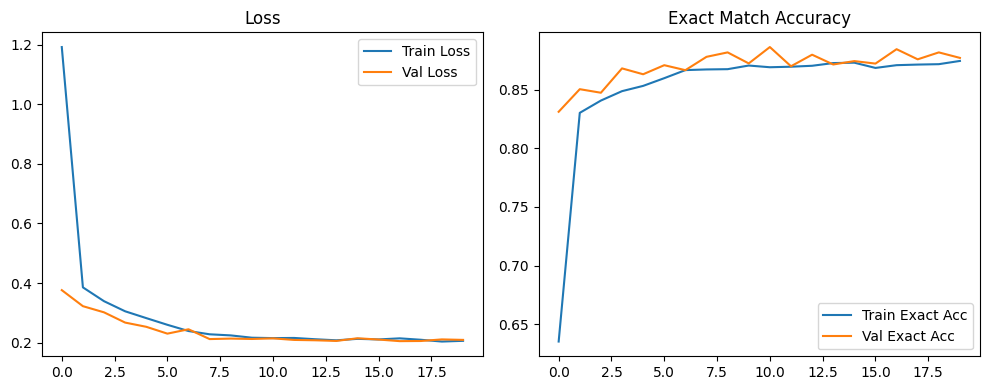

In [9]:
#학습 곡선 시각화

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Exact Acc")
plt.plot(history["val_acc"],   label="Val Exact Acc")
plt.legend()
plt.title("Exact Match Accuracy")
plt.tight_layout()
plt.show()

In [10]:
#오답 예시 확인 (Validation 셋 기준)

#베스트 모델 가중치 다시 로드
BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "best_model.pt")
state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

error_examples = []
max_errors_to_show = 20

global_idx = 0

with torch.no_grad():
    for x, y_mood, y_tense, y_person in val_loader:
        x = x.to(device)
        y_mood = y_mood.to(device)
        y_tense = y_tense.to(device)
        y_person = y_person.to(device)

        out_mood, out_tense, out_person = model(x)

        mood_pred   = out_mood.argmax(1)
        tense_pred  = out_tense.argmax(1)
        person_pred = out_person.argmax(1)

        batch_size = x.size(0)

        for i in range(batch_size):
            # 각 샘플에 대해 정답/예측 비교
            true_mood   = y_mood[i].item()
            true_tense  = y_tense[i].item()
            true_person = y_person[i].item()

            pred_m      = mood_pred[i].item()
            pred_t      = tense_pred[i].item()
            pred_p      = person_pred[i].item()

            # 하나라도 다르면 "오답"
            if (true_mood != pred_m) or (true_tense != pred_t) or (true_person != pred_p):
                row = val_df.iloc[global_idx + i]

                error_examples.append({
                    "verb": row["verb"],
                    "gold_mood":   mood_le.inverse_transform([true_mood])[0],
                    "pred_mood":   mood_le.inverse_transform([pred_m])[0],
                    "gold_tense":  tense_le.inverse_transform([true_tense])[0],
                    "pred_tense":  tense_le.inverse_transform([pred_t])[0],
                    "gold_person": person_le.inverse_transform([true_person])[0],
                    "pred_person": person_le.inverse_transform([pred_p])[0],
                })

                if len(error_examples) >= max_errors_to_show:
                    break

        global_idx += batch_size

        if len(error_examples) >= max_errors_to_show:
            break

# pandas DataFrame으로 보기 좋게 출력
errors_df = pd.DataFrame(error_examples)
print(f"총 {len(errors_df)}개 오답 예시 (상위 몇 개만 표시):")
display(errors_df.head(20))


총 20개 오답 예시 (상위 몇 개만 표시):


,verb,gold_mood,pred_mood,gold_tense,pred_tense,gold_person,pred_person
0,yerren,subjunctive,imperative,present,present,3pl,3pl
1,tocara,subjunctive,subjunctive,imperfect,imperfect,1sg,3sg
2,hubiera distinguido,subjunctive,subjunctive,pluperfect,pluperfect,1sg,3sg
3,cesamos,indicative,indicative,preterite,present,1pl,1pl
4,tropezara,subjunctive,subjunctive,imperfect,imperfect,1sg,3sg
5,había prometido,indicative,indicative,pluperfect,pluperfect,1sg,3sg
6,generalizaba,indicative,indicative,imperfect,imperfect,1sg,3sg
7,copiaría,indicative,indicative,conditional,conditional,1sg,3sg
8,haya limpiado,subjunctive,subjunctive,present_perfect,present_perfect,1sg,3sg
9,haya entrevistado,subjunctive,subjunctive,present_perfect,present_perfect,1sg,3sg
